#### Row-Major Ordering

In [1]:
import sys
import time
import numpy as np
import nexpy as nxp
import nexpy.core.triangular as tri
from IPython.display import display
from scipy.sparse import csr_matrix

In [2]:
# SECTION : SUBSECTION
    # (markdown introduction)
    # METHODS : DESCRIPTION
    # PARAMETERS : DESCRIPTION
    # COMPUTATIONS : DESCRIPTION
    # OUTPUTS : DESCRIPTION

#### Experiments

In [3]:
# METHODS: construction, storage and runtime statistics

def construction_stat(A):
    # [RowMajorOrdering, csr_matrix, np.array]
    res = [] 
    
    # Construct from RowMajorOrdering
    start=time.time()
    mat_rmo = tri.RowMajorOrdering(A)
    res.append((time.time()-start)*1e3)
    
    # Construction of SciPy csr (compressed sparse row) matrix 
    start=time.time()
    mat_csr = csr_matrix(A)
    res.append((time.time()-start)*1e3)

    # Construct from NumPy tril
    start = time.time()
    mat_np = np.tril(A, k=0)
    res.append((time.time()-start)*1e3)
    
    # Return matrices and results
    return mat_rmo, mat_csr, mat_np, np.array(res)
    

def storage_stat(mat_rmo, mat_csr, mat_np): 
    # [RowMajorOrdering, csr_matrix, np.array]
    res = [] 
    
    # Compute storage sizes
    res.append(sys.getsizeof(mat_rmo) + mat_rmo.bytes)
    res.append(sys.getsizeof(mat_csr) + mat_csr.data.nbytes + mat_csr.indices.nbytes + mat_csr.indptr.nbytes)
    res.append(sys.getsizeof(mat_np))
    
    # Return results
    return np.array(res)


def runtime_stat(mat_rmo, mat_csr, mat_np, vec):
    
    # [RowMajorOrdering, csr_matrix, np.array]
    res = [] 
    
    # Run rmo matrix-vector Product
    start_time = time.time()
    mat_rmo.dot(vec)
    res.append((time.time() - start_time)*1e3)
    
    # Run SciPy CSR matrix-vector product
    start_time = time.time()
    mat_csr.dot(vec)
    res.append((time.time() - start_time)*1e3)
    
    # Run NumPy array matrix-vector product
    start_time = time.time()
    mat_np.dot(vec)
    res.append((time.time() - start_time)*1e3)
    
    # Return results
    return np.array(res)

In [4]:
# METHODS : statistics handler

def stat_handler(mat_sizes: np.array, I = 10):
    # I ... the amount of iterations averaged in each step referring mv-products
    
    # Length of mat_sizes
    l = len(mat_sizes)
    
    # Display empty progress bar
    pb = display(nxp.visual.html.progress_bar(0), display_id=True)
    
    # Initialise statistics [RowMajorOrdering, csr_matrix, np.array]
    runtimes_c, storages, avg_runtimes = np.zeros((3, l, 3)) 
    sigma_runtimes = np.zeros((l, 3)) 

    for j, n in enumerate(mat_sizes):
        
        # Produce np pesudo random matrix
        A = np.random.rand(n, n)
        
        # Add construction time to statistics
        mat_rmo, mat_csr, mat_np, runtimes_c[j] = construction_stat(A)
        
        # Add storage to statistics
        storages[j] = storage_stat(mat_rmo, mat_csr, mat_np)
        
        # Initialise runtime dummy
        runtime = np.zeros((I, 3))
        
        # Compute the matrix vector product
        for i in range(I):
            
            # Produce np pseudo random vector
            vec = np.random.rand(n)
            
            # Run matrix-vector products
            runtime[i] = runtime_stat(mat_rmo, mat_csr, mat_np, vec)

        # Compute mean, add to averaged runtimes and compute standard deviation (without scale) to statistics
        runtime_mean = np.mean(runtime, axis=0)
        avg_runtimes[j] = runtime_mean
        sigma_runtimes[j] = np.sqrt(np.sum((runtime-np.array([runtime_mean]*I))**2, axis=0))
        
        # Update progress bar
        progress = int(100*(j+1)/l)
        pb.update(nxp.visual.html.progress_bar(progress))

    return runtimes_c, storages, avg_runtimes, sigma_runtimes

In [5]:
# PARAMETERS

captures = ["RMO", "SciPy CSR Matrix", "NumPy Array"]
mat_sizes = np.array([100*j for j in range(1, 51)])

In [7]:
# COMPUTATION : Run statistics handler

runtimes_c, storages, avg_runtimes, sigma_runtimes = stat_handler(mat_sizes)

In [8]:
# COMPUTATION : Prepare standard deviation plots

sigma_upper_runtimes = avg_runtimes + sigma_runtimes
sigma_lower_runtimes = avg_runtimes - sigma_runtimes

In [9]:
# OUTPUTS: Matrix sizes

print(mat_sizes)

[ 100  200  300  400  500  600  700  800  900 1000 1100 1200 1300 1400
 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800
 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200
 4300 4400 4500 4600 4700 4800 4900 5000]


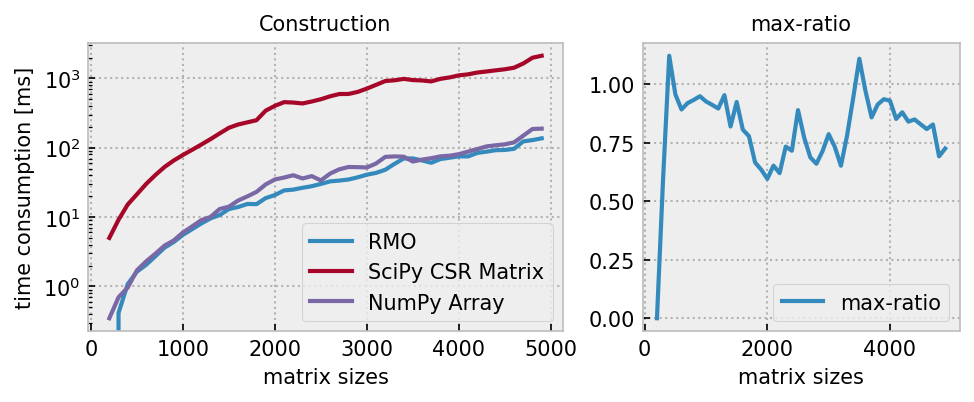

In [10]:
# OUTPUTS: Experiment plot construction runtime

# Applying a moving average with a fixed window size

window_size = 3
side_cut_off = int((window_size-1)/2)

ma_runtimes_c = np.array([nxp.utils.moving_average(itr, window_size).tolist() for itr in runtimes_c.T])

nxp.visual.plot.experiment(
    xticks   =mat_sizes[side_cut_off:-side_cut_off],
    plots    =[{'data': ma_runtimes_c[idm], 'label': capture}  for idm, capture in enumerate(captures)],
    title    ='Construction',
    xlabel   ='matrix sizes',
    ylabel   ='time consumption [ms]',
    fontsize=10,
    ylogscale=True,
    markers=False)

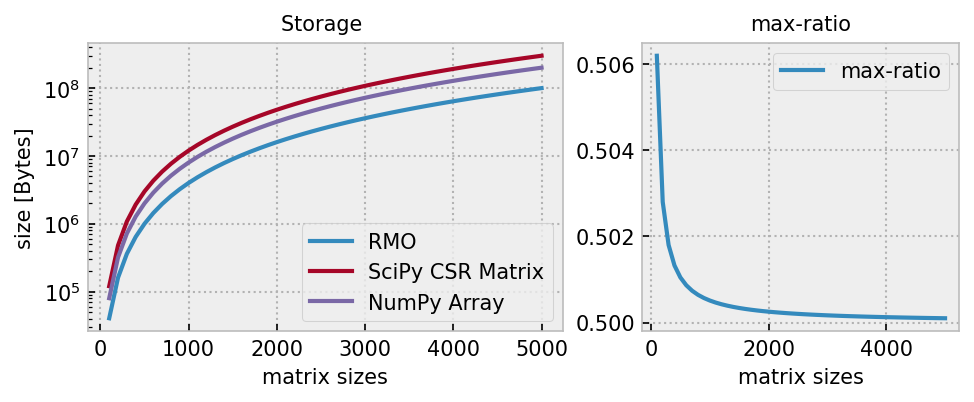

In [11]:
# OUTPUTS: Experiment plot storage

nxp.visual.plot.experiment(
    xticks   =mat_sizes,
    plots    =[{'data': storages.T[ids], 'label': capture} for ids, capture in enumerate(captures)],
    title    ='Storage ',
    xlabel   ='matrix sizes',
    ylabel   ='size [Bytes]',
    fontsize=10,
    ylogscale=True,
    markers=False)

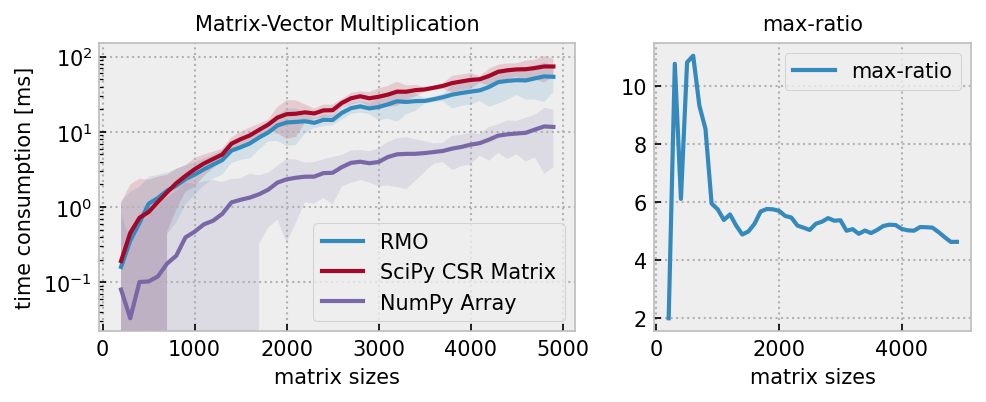

In [12]:
# OUTPUTS : Experiment plot averaged runtime

# Applying a moving average with a fixed window size

window_size = 3
side_cut_off = int((window_size-1)/2)

ma_avg_runtimes = np.array([nxp.utils.moving_average(ita, window_size).tolist() for ita in avg_runtimes.T])
ma_sigma_upper_runtimes = np.array([nxp.utils.moving_average(itv, window_size).tolist() for itv in sigma_upper_runtimes.T])
ma_sigma_lower_runtimes = np.array([nxp.utils.moving_average(itv, window_size).tolist() for itv in sigma_lower_runtimes.T])

nxp.visual.plot.experiment(
    xticks=mat_sizes[side_cut_off:-side_cut_off],
    plots =[{'data': ma_avg_runtimes[ida],
             'sigma_upper': ma_sigma_upper_runtimes[ida],
             'sigma_lower': ma_sigma_lower_runtimes[ida],
             'label': capture} for ida, capture in enumerate(captures)],
    title ='Matrix-Vector Multiplication',
    xlabel='matrix sizes',
    ylabel='time consumption [ms]',
    fontsize=10,
    ylogscale=True,
    markers=False)